# LSLGA Groups

The purpose of this notebook is to build a group catalog from the parent sample of large galaxies.  Galaxies near one another (projected on the sky) must be analyzed at the same time, so we use a simple friends-of-friends algorithm to generate our group catalog.

## Preliminaries

Import the libraries we need, define the I/O path, and specify the desired linking length (in arcminutes).

In [1]:
import os
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord

In [3]:
from pydl.pydlutils.spheregroup import spheregroup

In [4]:
%matplotlib inline

In [5]:
LSLGAdir = os.getenv('LSLGA_DIR')
linking_length = 1.0 # [arcmin]

## Read the parent HyperLeda catalog

In [6]:
ledafile = os.path.join(LSLGAdir, 'sample', 'leda-logd25-0.05.fits')
leda = Table.read(ledafile)
leda

GALAXY,PGC,RA,DEC,TYPE,OBJTYPE,MULTIPLE,D25,BA,PA,BMAG,IMAG,VHELIO
str28,str10,float64,float64,str4,str2,str1,float32,float32,float32,float32,float32,float32
PGC2456621,PGC2456621,0.0003,53.99049,,g,,34.5264,0.338844,48.0,17.24,-999.0,-999.0
PGC622563,PGC0622563,0.00045,-37.47607,,G,,17.7073,0.758578,128.0,17.75,15.84,-999.0
PGC1191650,PGC1191650,0.00045,1.33245,,g,,13.7452,0.812831,84.0,19.05,-999.0,-999.0
PGC639648,PGC0639648,0.00045,-36.19886,,G,,12.8278,0.891251,100.0,18.58,-999.0,-999.0
PGC1982072,PGC1982072,0.0006,32.1366,,G,,19.4156,0.74131,136.5,17.78,-999.0,-999.0
PGC535833,PGC0535833,0.0006,-44.57789,,G,,20.3306,0.588844,148.5,17.63,17.14,-999.0
PGC520795,PGC0520795,0.00075,-45.95405,,G,,20.3306,0.676083,24.7,17.54,15.5,-999.0
SDSSJ000000.16-001108.5,PGC4165833,0.00075,-0.18576,,G,,10.9182,0.912011,-999.0,18.89,17.5,58476.0
PGC1961515,PGC1961515,0.00075,31.7311,,G,,23.3427,0.616595,160.3,17.38,-999.0,-999.0


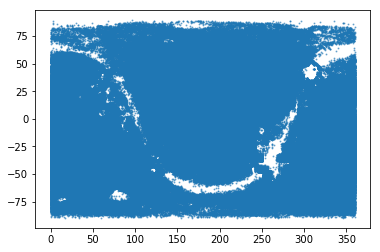

In [7]:
fig, ax = plt.subplots()
ax.scatter(leda['RA'], leda['DEC'], s=1, alpha=0.5)

In [8]:
#these = (leda['RA'] > 200) * (leda['RA'] < 220) * (leda['DEC'] > 0) * (leda['DEC'] < 10.0)
#leda = leda[these]
#print(np.sum(these))

## Run FoF with spheregroup

Identify groups using a simple angular linking length.  Then construct a catalog of group properties.

In [9]:
grp, mult, frst, nxt = spheregroup(leda['RA'], leda['DEC'], linking_length/60.0)

In [10]:
npergrp, _ = np.histogram(grp, bins=len(grp), range=(0, len(grp)))
nbiggrp = np.sum(npergrp > 1).astype('int')
nsmallgrp = np.sum(npergrp == 1).astype('int')
ngrp = nbiggrp + nsmallgrp

In [11]:
print('Found {} total groups, including:'.format(ngrp))
print('  {} groups with 1 member'.format(nsmallgrp))
print('  {} groups with 2-5 members'.format(np.sum( (npergrp > 1)*(npergrp <= 5) ).astype('int')))
print('  {} groups with 5-10 members'.format(np.sum( (npergrp > 5)*(npergrp <= 10) ).astype('int')))
print('  {} groups with >10 members'.format(np.sum( (npergrp > 10) ).astype('int')))

Found 1954591 total groups, including:
  1800104 groups with 1 member
  153656 groups with 2-5 members
  785 groups with 5-10 members
  46 groups with >10 members


## Populate the output group catalog

In [12]:
groupcat = Table()
groupcat.add_column(Column(name='GROUPID', dtype='i4', length=ngrp, data=np.arange(ngrp))) # unique ID number
groupcat.add_column(Column(name='GALAXY', dtype='S500', length=ngrp))
groupcat.add_column(Column(name='NMEMBERS', dtype='i4', length=ngrp))
groupcat.add_column(Column(name='RA', dtype='f8', length=ngrp))  # average RA
groupcat.add_column(Column(name='DEC', dtype='f8', length=ngrp)) # average Dec
groupcat.add_column(Column(name='RADIUS', dtype='f4', length=ngrp))

#### Groups with one member--

In [13]:
smallindx = np.arange(nsmallgrp)

In [14]:
ledaindx = np.where(npergrp == 1)[0]
groupcat['RA'][smallindx] = leda['RA'][ledaindx]
groupcat['DEC'][smallindx] = leda['DEC'][ledaindx]
groupcat['NMEMBERS'][smallindx] = 1
groupcat['GALAXY'][smallindx] = np.char.strip(leda['GALAXY'][ledaindx])
groupcat['RADIUS'][smallindx] = leda['D25'][ledaindx] / 2.0 # [arcsec]

#### Groups with more than one member--

In [15]:
bigindx = np.arange(nbiggrp) + nsmallgrp

In [16]:
coord = SkyCoord(ra=leda['RA']*u.degree, dec=leda['DEC']*u.degree)

In [17]:
for grpindx, indx in zip(bigindx, np.where(npergrp > 1)[0]):
    ledaindx = np.where(grp == indx)[0]
    
    groupcat['RA'][grpindx] = np.mean(leda['RA'][ledaindx])
    groupcat['DEC'][grpindx] = np.mean(leda['DEC'][ledaindx])
    groupcat['NMEMBERS'][grpindx] = len(ledaindx)
    groupcat['GALAXY'][grpindx] = ','.join(np.char.strip(leda['GALAXY'][ledaindx]))

    sep = []
    for onecc in coord[ledaindx][1:]:
        sep.append(coord[ledaindx].separation(onecc).arcsec.max())
    sep = np.array(sep)
    groupcat['RADIUS'][grpindx] = np.max( (sep.max(), np.max(leda['D25'][ledaindx] / 2)) )

In [18]:
groupcat

GROUPID,GALAXY,NMEMBERS,RA,DEC,RADIUS
int32,bytes500,int32,float64,float64,float32
0,PGC2456621,1,0.0003,53.99049,17.2632
1,PGC622563,1,0.00045,-37.47607,8.85363
2,PGC1191650,1,0.00045,1.33245,6.8726
3,PGC639648,1,0.00045,-36.19886,6.41389
4,PGC1982072,1,0.0006,32.1366,9.70781
5,PGC535833,1,0.0006,-44.57789,10.1653
6,PGC520795,1,0.00075,-45.95405,10.1653
7,SDSSJ000000.16-001108.5,1,0.00075,-0.18576,5.4591
8,PGC1961515,1,0.00075,31.7311,11.6714


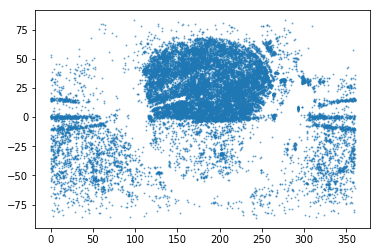

In [19]:
ww = np.where(groupcat['NMEMBERS'] > 2)[0]
fig, ax = plt.subplots()
ax.scatter(groupcat['RA'][ww], groupcat['DEC'][ww], s=1, alpha=0.5)

In [20]:
groupfile = os.path.join(LSLGAdir, 'sample', 'leda-logd25-0.05-groupcat.fits')
print('Writing {}'.format(groupfile))
groupcat.write(groupfile, overwrite=True)

Writing /Users/ioannis/research/projects/LSLGA/sample/leda-logd25-0.05-groupcat.fits
